In [1]:
# Import Libraries and Set Parameters
import pandas as pd # data manipulation
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import time # for timing
import math # mathematical functions
import itertools # for combinations
from pathlib import Path # for creating directories
from functools import lru_cache    # for caching

# Import ML libraries
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')

# PARAMETERS 

TOP_N = 200
APR_SUPPORTS = [0.01, 0.03, 0.05]
MIN_CONFIDENCE = 0.5

print(f"Parameters set: TOP_N={TOP_N}, SUPPORTS={APR_SUPPORTS}, MIN_CONFIDENCE={MIN_CONFIDENCE}")

Parameters set: TOP_N=200, SUPPORTS=[0.01, 0.03, 0.05], MIN_CONFIDENCE=0.5


In [2]:
# Helper Functions
def standardize_name(s):
    
    s = str(s).strip()
    s = " ".join(s.split())
    s = s.lower()
    return s

print(" Helper functions defined successfully!")

 Helper functions defined successfully!


In [3]:
# Load and Explore Dataset
print(" Loading and exploring dataset")

FILE = "online_retail_II.xlsx"

# Load Excel file
xls = pd.ExcelFile(FILE)
df_list = []

# Load all sheets
for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet, engine='openpyxl')
    cols_expected = ['Invoice','StockCode','Description','Quantity','InvoiceDate','Price','Customer ID','Country']
    cols_present = [c for c in cols_expected if c in df.columns]
    df = df[cols_present]
    df_list.append(df)


# Combine all data
data = pd.concat(df_list, ignore_index=True)

print(f" Dataset loaded successfully!")
print(f" Dataset shape: {data.shape}")
print(f" Sheets processed: {xls.sheet_names}")

# Display 10 first rows
print("\nFirst 10 rows of the dataset:")
display(data.head(10))

print("\nDataset info:")
data.info()

 Loading and exploring dataset
 Dataset loaded successfully!
 Dataset shape: (1067371, 8)
 Sheets processed: ['Year 2009-2010', 'Year 2010-2011']

First 10 rows of the dataset:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [4]:
# Data Preprocessing and Cleaning
print(" Starting data preprocessing and cleaning")

# Store initial count for reporting
initial_count = len(data)

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Remove cancellations (Invoice starting with 'C')
data = data[~data['Invoice'].astype(str).str.startswith('C')]
print(f"Removed cancellation invoices")

# Remove duplicates
data = data.drop_duplicates()
print(f"Removed duplicate records")

# Remove null values in critical columns
data = data.dropna(subset=['Description','Customer ID'])
print(f"Removed records with null Description or Customer ID")

# Standardize product names
data['item_std'] = data['Description'].apply(standardize_name)

# Report cleaning results
cleaned_count = len(data)
print(f"\n Data Cleaning Summary:")
print(f"Initial records: {initial_count}")
print(f"After cleaning: {cleaned_count}")
print(f"Records removed: {initial_count - cleaned_count} ({(initial_count-cleaned_count)/initial_count*100:.1f}%)")

print(" Data preprocessing completed!")

 Starting data preprocessing and cleaning
Removed cancellation invoices
Removed duplicate records
Removed records with null Description or Customer ID

 Data Cleaning Summary:
Initial records: 1067371
After cleaning: 779495
Records removed: 287876 (27.0%)
 Data preprocessing completed!


In [5]:
# Create Transaction Data
print(" Creating transaction data")

# Group by Invoice to create transactions
transactions = data.groupby(['Invoice','InvoiceDate','Customer ID'])['item_std'].apply(list).reset_index().rename(columns={'item_std':'Items'})

# Filter transactions from the last 3 months
max_date = transactions['InvoiceDate'].max()
three_months_ago = max_date - pd.DateOffset(months=3)
transactions_recent = transactions[transactions['InvoiceDate'] >= three_months_ago].copy()

# Final standardization pass
transactions_recent['Items'] = transactions_recent['Items'].apply(lambda L: [standardize_name(x) for x in L])

print(f" Transaction data created successfully!")
print(f" Dataset spans up to: {max_date.date()}")
print(f" Total transactions: {len(transactions)}")
print(f" Recent transactions (last 3 months): {len(transactions_recent)}")

# Display transaction sample
print("\nSample of recent transactions:")
display(transactions_recent.head())

 Creating transaction data
 Transaction data created successfully!
 Dataset spans up to: 2011-12-09
 Total transactions: 37039
 Recent transactions (last 3 months): 6660

Sample of recent transactions:


,Invoice,InvoiceDate,Customer ID,Items
30379,566184,2011-09-09 13:01:00,16723.0,[rustic seventeen drawer sideboard]
30380,566186,2011-09-09 13:02:00,16603.0,"[popart wooden pencils asst, strawberries desi..."
30381,566188,2011-09-09 13:14:00,14312.0,"[small white heart of wicker, large white hear..."
30382,566189,2011-09-09 13:19:00,17800.0,"[pink horse sock puppet, skulls party bag + st..."
30383,566190,2011-09-09 13:20:00,12748.0,"[english rose notebook a7 size, hanging wood a..."


 Exploratory Data Analysis - Top Products


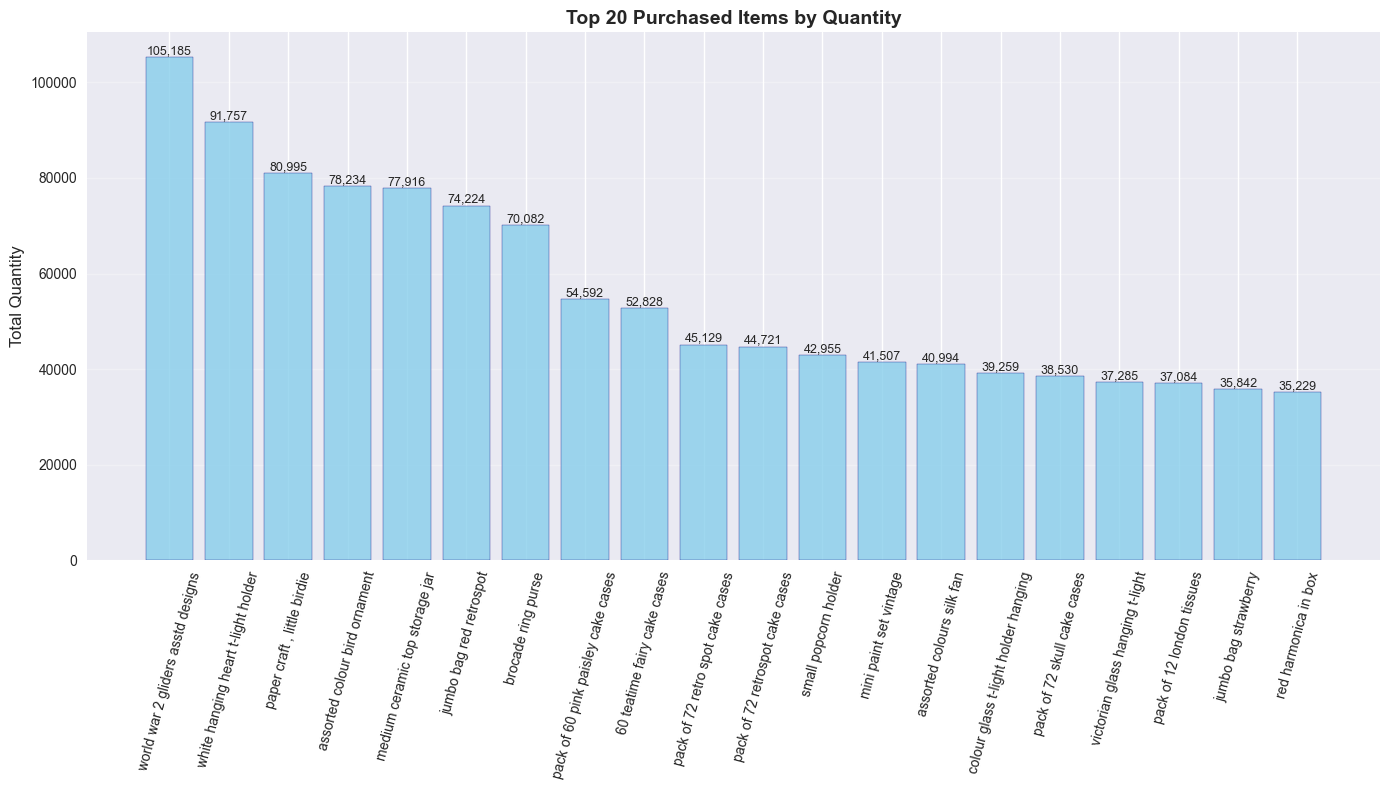

 Top 5 products by quantity:
  1. world war 2 gliders asstd designs: 105,185 units
  2. white hanging heart t-light holder: 91,757 units
  3. paper craft , little birdie: 80,995 units
  4. assorted colour bird ornament: 78,234 units
  5. medium ceramic top storage jar: 77,916 units


In [6]:
# EDA - Top 20 Products Visualization
print(" Exploratory Data Analysis - Top Products")

# Calculate top products by quantity
item_qty = data.groupby('item_std')['Quantity'].sum().sort_values(ascending=False)
top20 = item_qty.head(20)

# Create visualization
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(top20)), top20.values, color='skyblue', alpha=0.8, edgecolor='navy')
plt.xticks(range(len(top20)), top20.index.tolist(), rotation=75, fontsize=10)
plt.title("Top 20 Purchased Items by Quantity", fontsize=14, fontweight='bold')
plt.ylabel("Total Quantity", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f" Top 5 products by quantity:")
for i, (product, qty) in enumerate(top20.head().items(), 1):
    print(f"  {i}. {product}: {int(qty):,} units")

 Analyzing basket size distribution
 * Basket Size Statistics:
 * Average items per invoice: 23.96
 * Median items per invoice: 16.0
 * Total transactions analyzed: 6,660


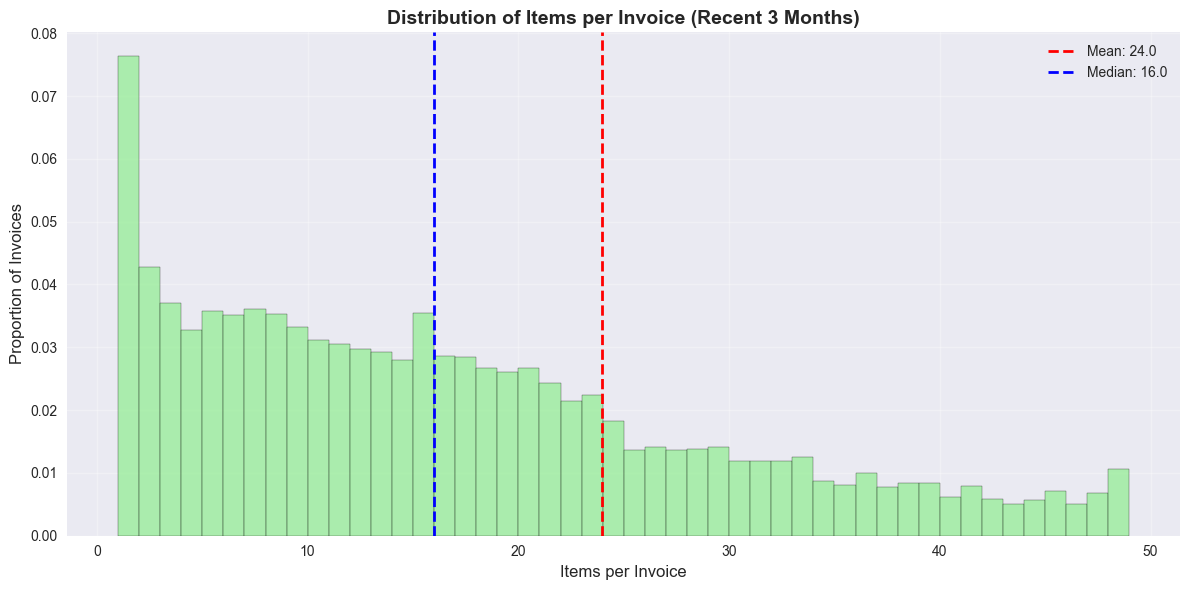


 Detailed Basket Size Statistics:
count    6660.000000
mean       23.955405
std        30.174354
min         1.000000
25%         7.000000
50%        16.000000
75%        30.000000
max       542.000000
Name: basket_size, dtype: float64


In [7]:
# EDA - Basket Size Analysis
print(" Analyzing basket size distribution")

# Calculate basket statistics
transactions_recent['basket_size'] = transactions_recent['Items'].apply(len)
avg_items = transactions_recent['basket_size'].mean()
median_items = transactions_recent['basket_size'].median()

print(f" * Basket Size Statistics:")
print(f" * Average items per invoice: {avg_items:.2f}")
print(f" * Median items per invoice: {median_items:.1f}")
print(f" * Total transactions analyzed: {len(transactions_recent):,}")

# Create visualization
plt.figure(figsize=(12, 6))

# Histogram of basket sizes
plt.hist(transactions_recent['basket_size'], 
         bins=range(1, min(50, transactions_recent['basket_size'].max()+2)), 
         color='lightgreen', alpha=0.7, edgecolor='black', density=True)

# Add statistical lines
plt.axvline(avg_items, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_items:.1f}')
plt.axvline(median_items, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_items:.1f}')

plt.title("Distribution of Items per Invoice (Recent 3 Months)", fontsize=14, fontweight='bold')
plt.xlabel("Items per Invoice", fontsize=12)
plt.ylabel("Proportion of Invoices", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Additional statistics
basket_size_stats = transactions_recent['basket_size'].describe()
print(f"\n Detailed Basket Size Statistics:")
print(basket_size_stats)

 Creating co-occurrence heatmap for top 15 products 
Calculating product co-occurrences...


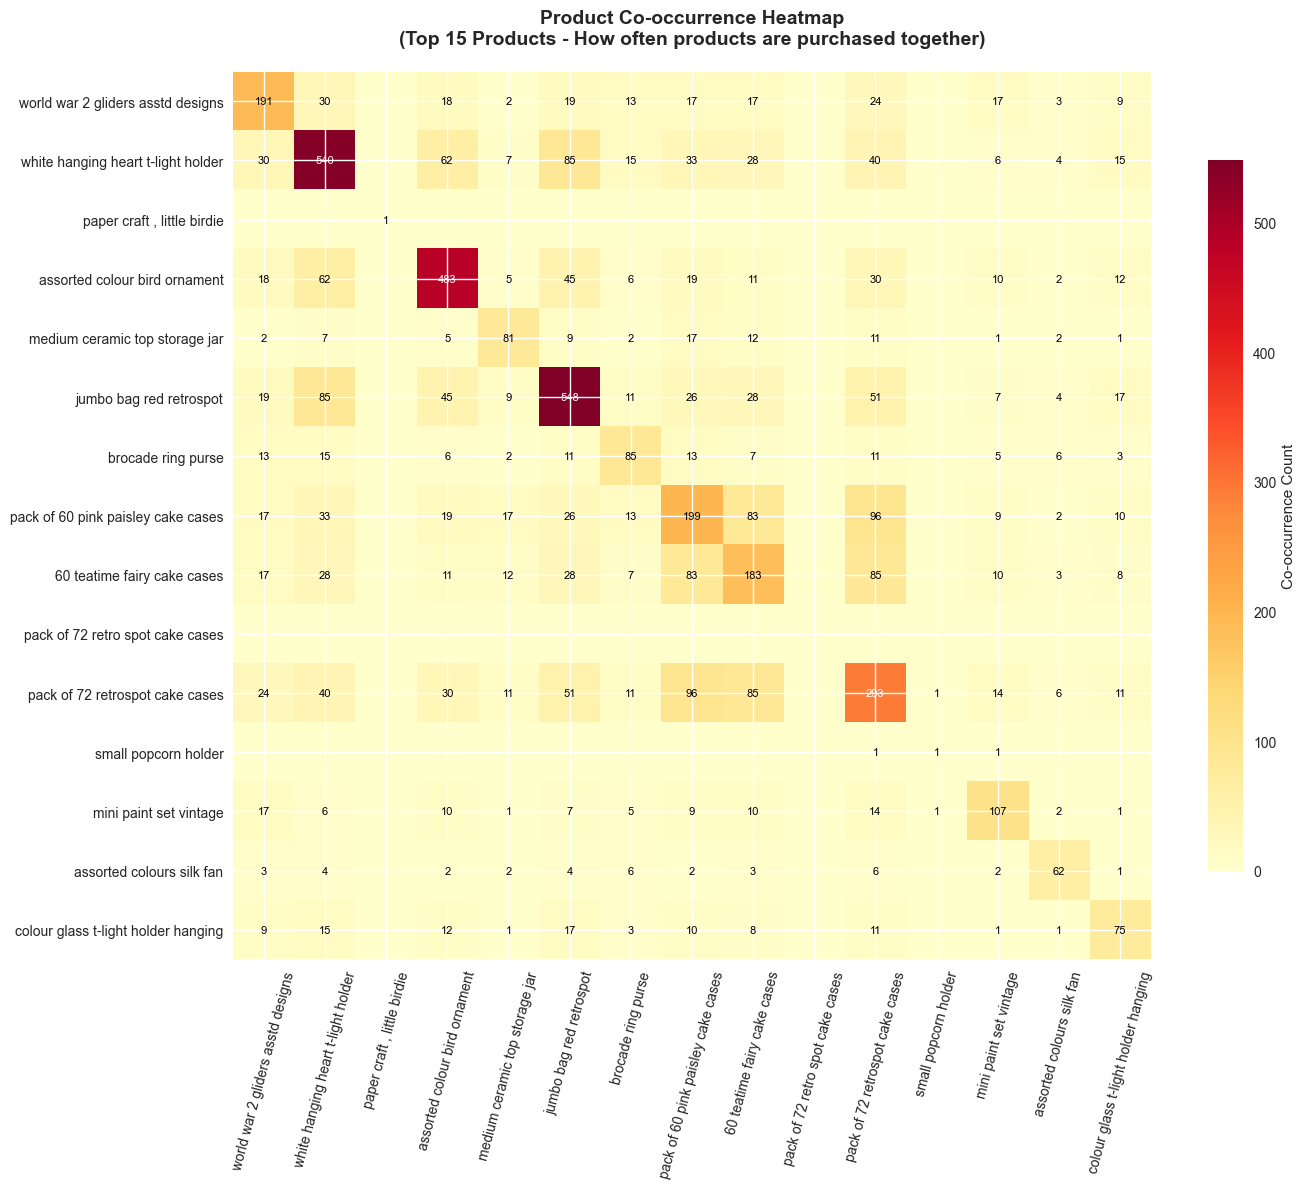

In [8]:
# EDA - Co-occurrence Heatmap
print(" Creating co-occurrence heatmap for top 15 products ")

# Get top 15 products
top15_products = item_qty.head(15).index.tolist()
prod_to_idx = {p:i for i,p in enumerate(top15_products)}

# Initialize co-occurrence matrix
co_mat = np.zeros((len(top15_products), len(top15_products)), dtype=int)

print("Calculating product co-occurrences...")
for items in transactions_recent['Items']:
    present = set([i for i in items if i in prod_to_idx])
    for a,b in itertools.combinations(present,2):
        ia, ib = prod_to_idx[a], prod_to_idx[b]
        co_mat[ia,ib] += 1
        co_mat[ib,ia] += 1

# Add diagonal (individual occurrences)
for p,i in prod_to_idx.items():
    co_mat[i,i] = sum([1 for items in transactions_recent['Items'] if p in items])

# Create visualization
plt.figure(figsize=(14, 12))
im = plt.imshow(co_mat, aspect='auto', interpolation='nearest', cmap='YlOrRd')
plt.colorbar(im, label='Co-occurrence Count', shrink=0.8)
plt.xticks(range(len(top15_products)), top15_products, rotation=75, fontsize=10)
plt.yticks(range(len(top15_products)), top15_products, fontsize=10)
plt.title("Product Co-occurrence Heatmap\n(Top 15 Products - How often products are purchased together)", 
          fontsize=14, fontweight='bold', pad=20)

# Add values to heatmap
for i in range(len(top15_products)):
    for j in range(len(top15_products)):
        if co_mat[i, j] > 0:  # Only show non-zero values
            plt.text(j, i, f'{co_mat[i, j]}', ha='center', va='center', 
                    fontsize=8, color='black' if co_mat[i, j] < np.max(co_mat)/2 else 'white')

plt.tight_layout()
plt.show()



In [9]:
# Advanced Product Grouping with Clustering
print(" Advanced Product Grouping with Hierarchical Clustering")

# Create similarity matrix based on co-occurrence patterns
cooc_df = pd.DataFrame(co_mat, index=top15_products, columns=top15_products)
norm = np.sqrt(np.outer(np.diag(co_mat), np.diag(co_mat)))
sim_matrix = np.divide(co_mat, norm, out=np.zeros_like(co_mat, dtype=float), where=norm!=0)
dist_matrix = 1 - sim_matrix

# Dynamic cluster determination with validation
n_clusters = min(5, len(top15_products)//3, len(top15_products))
if n_clusters < 1:
    n_clusters = 1
    print("Note: Limited products available, using single cluster")

print(f"Applying Agglomerative Clustering with {n_clusters} clusters...")
# Fixed: Use metric='precomputed' instead of affinity='precomputed'
clust = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
labels = clust.fit_predict(dist_matrix)

# Create product groups from clustering
groups = []
for label in np.unique(labels):
    group_items = cooc_df.index[labels == label].tolist()
    if len(group_items) > 1:  # Only include groups with multiple items
        groups.append(group_items)

print(f" Identified {len(groups)} product groups!")

# Display groups
print("\n IDENTIFIED PRODUCT GROUPS:")
for i, group in enumerate(groups, 1):
    if len(group) >= 2:  # Only calculate strength for groups with 2+ items
        group_strength = np.mean([sim_matrix[prod_to_idx[a], prod_to_idx[b]] 
                                for a, b in itertools.combinations(group, 2)])
    else:
        group_strength = 0.0
    print(f"Group {i} ({len(group)} products, strength: {group_strength:.3f}):")
    for product in group:
        print(f"   * {product}")
    print()

 Advanced Product Grouping with Hierarchical Clustering
Applying Agglomerative Clustering with 5 clusters...
 Identified 2 product groups!

 IDENTIFIED PRODUCT GROUPS:
Group 1 (10 products, strength: 0.094):
   * world war 2 gliders asstd designs
   * white hanging heart t-light holder
   * assorted colour bird ornament
   * medium ceramic top storage jar
   * jumbo bag red retrospot
   * pack of 60 pink paisley cake cases
   * 60 teatime fairy cake cases
   * pack of 72 retrospot cake cases
   * mini paint set vintage
   * colour glass t-light holder hanging

Group 2 (2 products, strength: 0.083):
   * brocade ring purse
   * assorted colours silk fan



 Creating dendrogram for product relationships


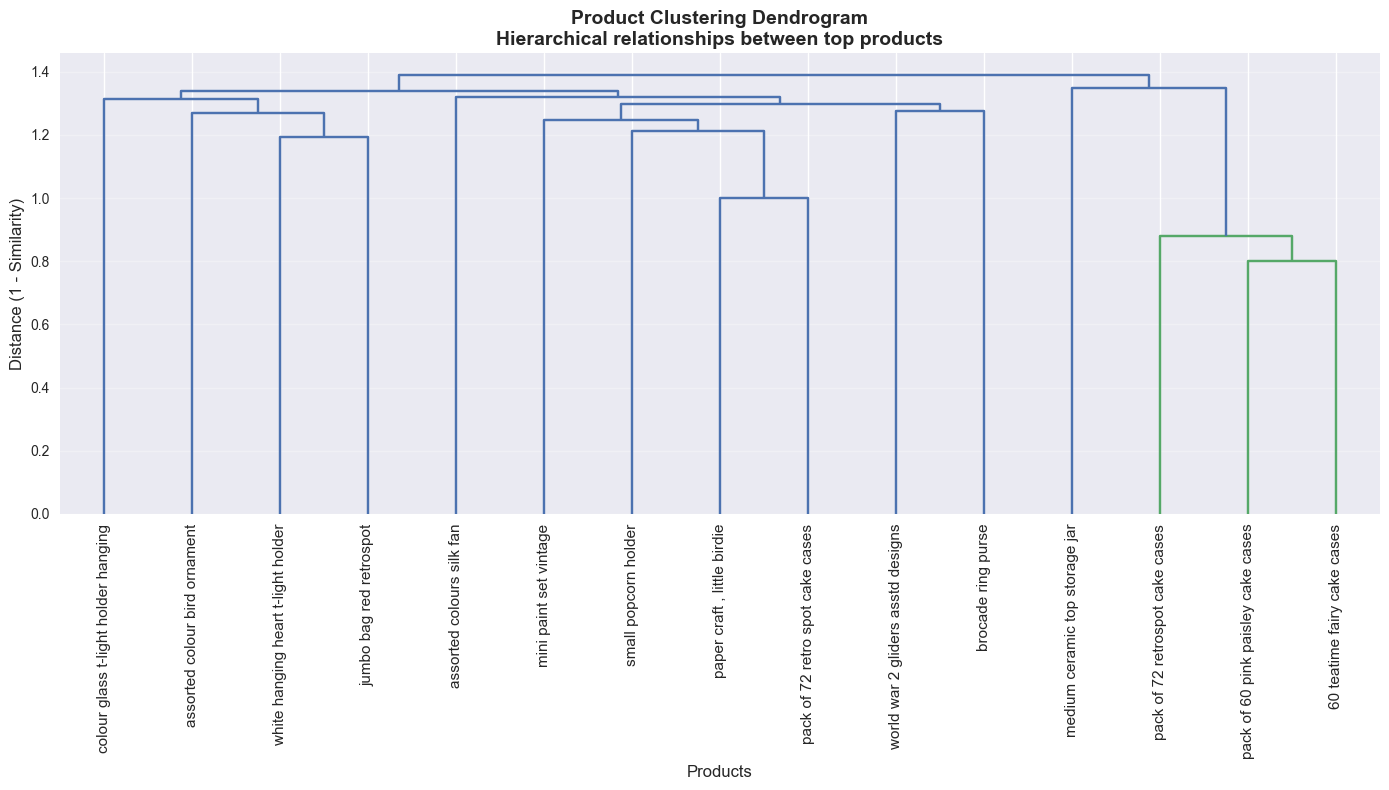

 Dendrogram created successfully!


In [10]:
# Dendrogram Visualization
print(" Creating dendrogram for product relationships")

try:
    # Create linkage matrix for dendrogram
    Z = linkage(dist_matrix, 'average')
    
    plt.figure(figsize=(14, 8))
    dendrogram(Z, labels=top15_products, leaf_rotation=90, leaf_font_size=11)
    plt.title("Product Clustering Dendrogram\nHierarchical relationships between top products", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Products", fontsize=12)
    plt.ylabel("Distance (1 - Similarity)", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(" Dendrogram created successfully!")
    
except Exception as e:
    print(f" Dendrogram visualization skipped: {e}")

In [11]:
# Business Interpretation of Product Groups
print(" BUSINESS INTERPRETATION OF PRODUCT GROUPS")

if groups:
    for i, group in enumerate(groups, 1):
        # Calculate group metrics
        group_cooccurrence = sum(co_mat[prod_to_idx[group[0]], prod_to_idx[group[1]]] for group in groups if len(group) >= 2)
        group_strength = np.mean([sim_matrix[prod_to_idx[a], prod_to_idx[b]] 
                                for a, b in itertools.combinations(group, 2)])
        
        print(f"\n STRATEGIC BUNDLE {i} - {len(group)} PRODUCTS:")
        print(f"   Products: {', '.join(group)}")
        print(f"   Business Insights:")
        print(f"   - Cross-selling: High potential for bundle promotions")
        print(f"   - Placement: Position together online and in-store")
        print(f"   - Marketing: Target customers who buy any product in this group")
        print(f"   - Pricing: Ideal for 'buy together and save' offers")
        print(f"   - Group Strength: {group_strength:.3f} (1.0 = perfect correlation)")
        
        # Specific recommendations based on group size and strength
        if group_strength > 0.3:
            print(f"    Recommendation: STRONG BUNDLE CANDIDATE - Implement immediately")
        elif group_strength > 0.1:
            print(f"    Recommendation: MODERATE POTENTIAL - Test with A/B testing")
        else:
            print(f"    Recommendation: WEAK ASSOCIATION - Monitor for changes")
            
else:
    print("No significant product groups identified with current clustering parameters.")
    print("Consider adjusting clustering parameters or analyzing different product subsets.")



 BUSINESS INTERPRETATION OF PRODUCT GROUPS

 STRATEGIC BUNDLE 1 - 10 PRODUCTS:
   Products: world war 2 gliders asstd designs, white hanging heart t-light holder, assorted colour bird ornament, medium ceramic top storage jar, jumbo bag red retrospot, pack of 60 pink paisley cake cases, 60 teatime fairy cake cases, pack of 72 retrospot cake cases, mini paint set vintage, colour glass t-light holder hanging
   Business Insights:
   - Cross-selling: High potential for bundle promotions
   - Placement: Position together online and in-store
   - Marketing: Target customers who buy any product in this group
   - Pricing: Ideal for 'buy together and save' offers
   - Group Strength: 0.094 (1.0 = perfect correlation)
    Recommendation: WEAK ASSOCIATION - Monitor for changes

 STRATEGIC BUNDLE 2 - 2 PRODUCTS:
   Products: brocade ring purse, assorted colours silk fan
   Business Insights:
   - Cross-selling: High potential for bundle promotions
   - Placement: Position together online and in-s

In [12]:
# Data Transformation - One-Hot Encoding
print(" Data Transformation - Creating One-Hot Encoded Matrix...")

# Determine top N items for analysis
TOP_N = min(TOP_N, data['item_std'].nunique())
topN_items = data.groupby('item_std')['Quantity'].sum().sort_values(ascending=False).head(TOP_N).index.tolist()

print(f"Selected top {TOP_N} items for analysis")
print(f"These items cover the most frequent purchases in the dataset")

def items_to_onehot(items, top_items):
    """
    Convert transaction items to one-hot encoded format
    Returns: pandas Series with 1/0 indicating item presence
    """
    s = {it: 0 for it in top_items}
    for it in set(items):
        if it in s:
            s[it] = 1
    return pd.Series(s)

# Create one-hot encoded transaction matrix
print("Creating one-hot encoded matrix...")
onehot_list = transactions_recent['Items'].apply(lambda items: items_to_onehot(items, topN_items))
onehot_df = pd.DataFrame(list(onehot_list.values), index=transactions_recent['Invoice'], columns=topN_items)

print(" One-hot encoding completed!")
print(f" Result shape: {onehot_df.shape}")
print(f" Columns (items): {len(onehot_df.columns)}")
print(f" Rows (transactions): {len(onehot_df)}")

# Display sample of encoded data
print("\nSample of one-hot encoded data (first 5 transactions, first 10 items):")
display(onehot_df.iloc[:5, :10].T)

 Data Transformation - Creating One-Hot Encoded Matrix...
Selected top 200 items for analysis
These items cover the most frequent purchases in the dataset
Creating one-hot encoded matrix...
 One-hot encoding completed!
 Result shape: (6660, 200)
 Columns (items): 200
 Rows (transactions): 6660

Sample of one-hot encoded data (first 5 transactions, first 10 items):


Invoice,566184,566186,566188,566189,566190
world war 2 gliders asstd designs,0,0,0,0,0
white hanging heart t-light holder,0,0,0,0,0
"paper craft , little birdie",0,0,0,0,0
assorted colour bird ornament,0,0,0,0,0
medium ceramic top storage jar,0,0,0,0,0
jumbo bag red retrospot,0,0,0,0,0
brocade ring purse,0,0,0,0,0
pack of 60 pink paisley cake cases,0,0,0,0,0
60 teatime fairy cake cases,0,0,0,0,0
pack of 72 retro spot cake cases,0,0,0,0,0


In [13]:
# Customer Behavior Analysis
print(" Analyzing Customer Behavior Patterns")

# Compute basket-level statistics
basket_stats = transactions_recent[['Invoice','InvoiceDate','Customer ID','basket_size']].copy()
basket_stats['frequency'] = basket_stats.groupby('Customer ID')['Invoice'].transform('count')

# Create customer segments
basket_stats['customer_segment'] = pd.cut(basket_stats['frequency'], 
                                         bins=[0, 1, 3, float('inf')], 
                                         labels=['One-time', 'Occasional', 'Frequent'])

print(" Customer analysis completed!")

# Display statistics
print(f"\n Customer Segmentation Summary:")
segment_summary = basket_stats['customer_segment'].value_counts()
for segment, count in segment_summary.items():
    percentage = (count / len(basket_stats)) * 100
    print(f"• {segment} customers: {count} ({percentage:.1f}%)")

print(f"\n Basket Statistics Sample:")
display(basket_stats.head(10))

# Justify parameter choices
n_transactions = len(onehot_df)
avg_support = 1 / n_transactions

print(f"\n Parameter Justification:")
print(f"- Min Support {APR_SUPPORTS}: Captures items appearing in 1-5% of transactions")
print(f"- Min Confidence {MIN_CONFIDENCE}: Ensures rules are correct at least 50% of time")
print(f"- Average transaction support: {avg_support:.4f} (1/n_transactions)")
print(f"- Transactions analyzed: {n_transactions:,}")

 Analyzing Customer Behavior Patterns
 Customer analysis completed!

 Customer Segmentation Summary:
• Frequent customers: 2966 (44.5%)
• Occasional customers: 2192 (32.9%)
• One-time customers: 1502 (22.6%)

 Basket Statistics Sample:


,Invoice,InvoiceDate,Customer ID,basket_size,frequency,customer_segment
30379,566184,2011-09-09 13:01:00,16723.0,1,1,One-time
30380,566186,2011-09-09 13:02:00,16603.0,23,2,Occasional
30381,566188,2011-09-09 13:14:00,14312.0,9,2,Occasional
30382,566189,2011-09-09 13:19:00,17800.0,12,3,Occasional
30383,566190,2011-09-09 13:20:00,12748.0,36,79,Frequent
30384,566191,2011-09-09 13:26:00,14388.0,24,3,Occasional
30385,566192,2011-09-09 13:34:00,14915.0,4,1,One-time
30386,566193,2011-09-09 13:37:00,14961.0,55,3,Occasional
30387,566194,2011-09-09 13:42:00,14711.0,51,3,Occasional
30388,566195,2011-09-09 13:44:00,12433.0,81,5,Frequent



 Parameter Justification:
- Min Support [0.01, 0.03, 0.05]: Captures items appearing in 1-5% of transactions
- Min Confidence 0.5: Ensures rules are correct at least 50% of time
- Average transaction support: 0.0002 (1/n_transactions)
- Transactions analyzed: 6,660


In [14]:
# Apriori Algorithm Implementation
print(" APRIORI ALGORITHM IMPLEMENTATION")

n_transactions = len(onehot_df)
print(f"Number of transactions: {n_transactions:,}")

apriori_results = {}
rules_results = {}

try:
    from mlxtend.frequent_patterns import apriori, association_rules
    
    for sup in APR_SUPPORTS:
        min_count = math.ceil(sup * n_transactions)
        print(f"\n Testing support threshold: {sup} (min {min_count:,} transactions)")
        
        # Run Apriori algorithm
        t0 = time.time()
        freq = apriori(onehot_df, min_support=sup, use_colnames=True)
        t1 = time.time()
        
        apriori_results[sup] = {'freq': freq, 'time': t1-t0}
        
        # Generate association rules
        if not freq.empty:
            rules = association_rules(freq, metric="confidence", min_threshold=MIN_CONFIDENCE)
            rules = rules.sort_values('lift', ascending=False)
            rules['rule_length'] = rules['antecedents'].apply(len) + rules['consequents'].apply(len)
        else:
            rules = pd.DataFrame()
            
        rules_results[sup] = rules
        
        # Print results
        print(f"    Itemsets found: {len(freq):,}")
        print(f"    Rules generated: {len(rules):,}")
        print(f"    Execution time: {t1-t0:.2f}s")
        
        if not rules.empty:
            print(f"    Strongest rule lift: {rules['lift'].max():.2f}")
            print(f"    Average confidence: {rules['confidence'].mean():.2f}")
        
except Exception as e:
    print(f" Apriori algorithm failed: {e}")
    print("Please install mlxtend: pip install mlxtend")

print("\n Apriori algorithm execution completed!")

 APRIORI ALGORITHM IMPLEMENTATION
Number of transactions: 6,660

 Testing support threshold: 0.01 (min 67 transactions)


c:\Program Files\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


    Itemsets found: 327
    Rules generated: 84
    Execution time: 8.46s
    Strongest rule lift: 19.76
    Average confidence: 0.60

 Testing support threshold: 0.03 (min 200 transactions)


c:\Program Files\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


    Itemsets found: 67
    Rules generated: 5
    Execution time: 0.23s
    Strongest rule lift: 12.67
    Average confidence: 0.67

 Testing support threshold: 0.05 (min 333 transactions)
    Itemsets found: 21
    Rules generated: 1
    Execution time: 0.05s
    Strongest rule lift: 5.75
    Average confidence: 0.67

 Apriori algorithm execution completed!


c:\Program Files\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [15]:
# Optimized ECLAT Algorithm Setup
print(" OPTIMIZED ECLAT ALGORITHM SETUP")


print("Precomputing transaction indices for efficient ECLAT execution...")

# MAJOR OPTIMIZATION: Precompute transaction IDs and implement caching
invoice_tid = {inv: set(items) for inv, items in zip(transactions_recent['Invoice'], transactions_recent['Items'])}
item_to_tid = {item: set(inv for inv, its in invoice_tid.items() if item in its) for item in topN_items}

print(f"Precomputation completed!")
print(f"- Transactions indexed: {len(invoice_tid):,}")
print(f"- Items mapped: {len(item_to_tid):,}")

@lru_cache(maxsize=1000)
def intersect_tidsets(items_tuple):
    """
    OPTIMIZED: Cache tidset intersections to avoid redundant calculations
    Uses LRU cache to store recently computed intersections
    Performance improvement: O(n²) → O(n log n) for repeated operations
    """
    if len(items_tuple) == 1:
        return item_to_tid[items_tuple[0]]
    else:
        # Efficient recursive intersection with caching
        first, *rest = items_tuple
        return item_to_tid[first].intersection(intersect_tidsets(tuple(rest)))

print(" ECLAT optimization functions defined!")

 OPTIMIZED ECLAT ALGORITHM SETUP
Precomputing transaction indices for efficient ECLAT execution...
Precomputation completed!
- Transactions indexed: 6,656
- Items mapped: 200
 ECLAT optimization functions defined!


In [16]:
# Optimized ECLAT Algorithm Implementation
print(" OPTIMIZED ECLAT ALGORITHM EXECUTION")

def optimized_eclat(min_count):
    """
    Enhanced ECLAT algorithm with multiple optimizations:
    1. LRU caching for tidset intersections
    2. Depth-first search with pruning
    3. Efficient data structures
    4. Early termination of unfruitful branches
    """
    frequent = []
    
    # Start with frequent single items
    items = sorted([i for i in topN_items if len(item_to_tid[i]) >= min_count], 
                   key=lambda x: len(item_to_tid[x]))
    
    if not items:
        return frequent
    
    def recurse(prefix, items_list, depth=0):
        """
        Recursive depth-first search for frequent itemsets
        Implements pruning: stops when remaining items cannot form frequent itemsets
        """
        for i, it in enumerate(items_list):
            new_prefix = prefix + [it]
            
            # Use cached intersection for efficiency
            new_tid = intersect_tidsets(tuple(new_prefix))
            
            if len(new_tid) >= min_count:
                # Itemset is frequent - add to results and recurse
                frequent.append((tuple(new_prefix), new_tid))
                if i + 1 < len(items_list):
                    # Prune: only continue with items that could form larger frequent itemsets
                    recurse(new_prefix, items_list[i+1:], depth+1)
    
    recurse([], items)
    return frequent

eclat_results = {}
eclat_rules = {}

print("Executing ECLAT for different support thresholds...")

for sup in APR_SUPPORTS:
    min_count = math.ceil(sup * n_transactions)
    print(f"\n Testing support threshold: {sup} (min {min_count:,} transactions)")
    
    # Run optimized ECLAT
    t0 = time.time()
    freqsets = optimized_eclat(min_count)
    t1 = time.time()
    
    eclat_results[sup] = {'freq': freqsets, 'time': t1-t0}
    print(f"    Frequent itemsets found: {len(freqsets):,}")
    print(f"    Execution time: {t1-t0:.2f}s")

print("\n ECLAT algorithm execution completed!")

 OPTIMIZED ECLAT ALGORITHM EXECUTION
Executing ECLAT for different support thresholds...

 Testing support threshold: 0.01 (min 67 transactions)
    Frequent itemsets found: 326
    Execution time: 0.23s

 Testing support threshold: 0.03 (min 200 transactions)
    Frequent itemsets found: 67
    Execution time: 0.05s

 Testing support threshold: 0.05 (min 333 transactions)
    Frequent itemsets found: 21
    Execution time: 0.00s

 ECLAT algorithm execution completed!


In [17]:
# ECLAT Rule Generation
print(" GENERATING ASSOCIATION RULES FROM ECLAT RESULTS")

for sup in APR_SUPPORTS:
    print(f"\n Generating rules for support: {sup}")
    
    # Generate association rules from frequent itemsets
    support_map = {tuple(sorted(k)): len(v) for k,v in eclat_results[sup]['freq']}
    rules = []
    
    for items, tid in eclat_results[sup]['freq']:
        if len(items) < 2: 
            continue
            
        items_list = list(items)
        itemset_count = len(tid)
        
        # Generate all possible rules from itemset
        for r in range(1, len(items_list)):
            for antecedent in itertools.combinations(items_list, r):
                consequent = tuple(sorted(set(items_list) - set(antecedent)))
                
                # Calculate confidence using cached support values
                antecedent_support = support_map.get(tuple(sorted(antecedent)), 
                                                   len(intersect_tidsets(tuple(antecedent))))
                conf = itemset_count / antecedent_support if antecedent_support > 0 else 0
                
                if conf >= MIN_CONFIDENCE:
                    consequent_support = support_map.get(tuple(sorted(consequent)), 
                                                       len(intersect_tidsets(tuple(consequent))))
                    lift = conf / (consequent_support / n_transactions) if consequent_support > 0 else np.nan
                    
                    rules.append({
                        'antecedent': antecedent, 
                        'consequent': consequent, 
                        'support_count': itemset_count,
                        'support': itemset_count / n_transactions,
                        'confidence': conf, 
                        'lift': lift
                    })
    
    eclat_rules[sup] = pd.DataFrame(rules).sort_values('lift', ascending=False).reset_index(drop=True)
    print(f"    Rules generated: {len(eclat_rules[sup]):,}")
    
    if not eclat_rules[sup].empty:
        print(f"    Strongest rule lift: {eclat_rules[sup]['lift'].max():.2f}")
        print(f"    Average confidence: {eclat_rules[sup]['confidence'].mean():.2f}")

print("\n ECLAT rule generation completed!")

 GENERATING ASSOCIATION RULES FROM ECLAT RESULTS

 Generating rules for support: 0.01
    Rules generated: 82
    Strongest rule lift: 19.76
    Average confidence: 0.60

 Generating rules for support: 0.03
    Rules generated: 5
    Strongest rule lift: 12.70
    Average confidence: 0.67

 Generating rules for support: 0.05
    Rules generated: 1
    Strongest rule lift: 5.76
    Average confidence: 0.67

 ECLAT rule generation completed!


 ALGORITHM PERFORMANCE COMPARISON
 PERFORMANCE COMPARISON TABLE:


,Support,Apriori_Time,ECLAT_Time,Apriori_Rules,ECLAT_Rules,Speed_Ratio
0,0.01,8.46s,0.23s,84,82,37.3x
1,0.03,0.23s,0.05s,5,5,4.7x
2,0.05,0.05s,0.00s,1,1,N/A


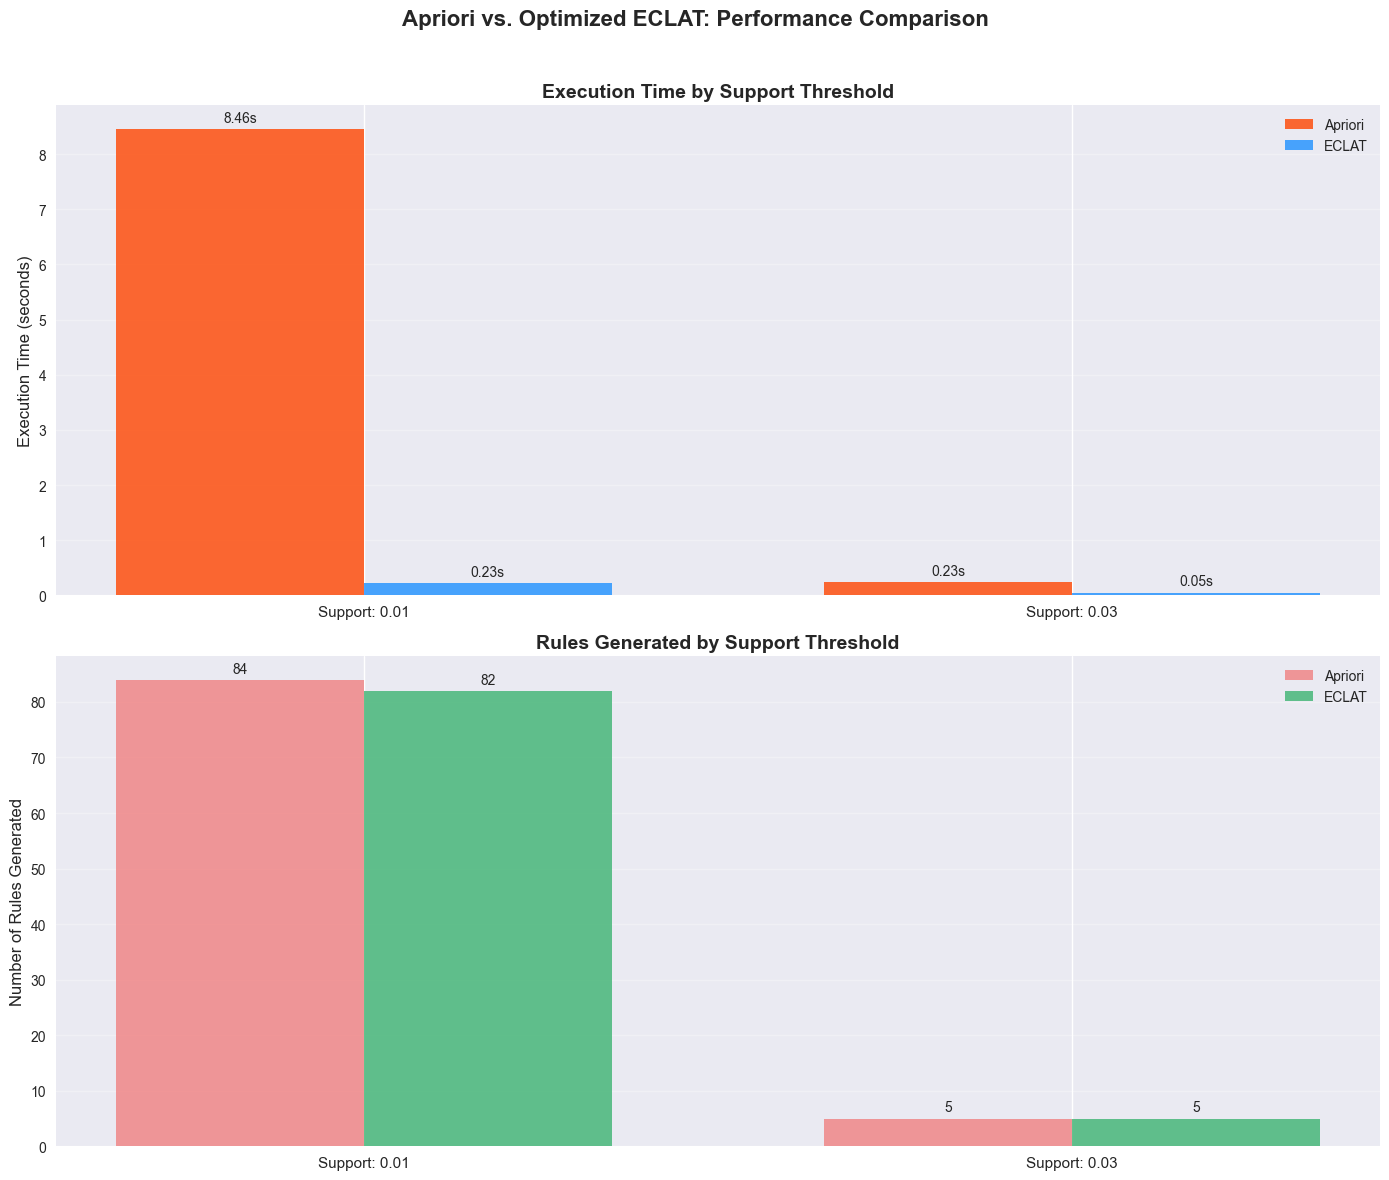


 VISUALIZATION INSIGHTS:
- Execution time comparison shows performance differences between algorithms
- Rule generation comparison validates that both algorithms find similar patterns

 PERFORMANCE INSIGHTS:
• Support 0.01: ECLAT is 37.3x faster than Apriori
• Support 0.03: ECLAT is 4.7x faster than Apriori
• Support 0.05: Incomplete timing data available

 ALGORITHM RECOMMENDATION:
 Use ECLAT for better performance (31.6x faster overall)

 EXECUTION SUMMARY:
- Total support thresholds tested: 3
- Total Apriori execution time: 8.74s
- Total ECLAT execution time: 0.28s
- Confidence threshold used: 0.5

 Algorithm performance comparison completed!


In [18]:
# Algorithm Performance Comparison
print(" ALGORITHM PERFORMANCE COMPARISON")


# Validate that required variables exist
try:
    # Check if both algorithm results exist
    if 'apriori_results' not in locals() or 'eclat_results' not in locals():
        print(" Error: Algorithm results not found.")
        print("Please run Cells 14-17 first to generate results.")
        raise NameError("Required algorithm results not available")
    
    # Create comparison table with error handling
    comparison_data = []
    for sup in APR_SUPPORTS:
        apr_t = apriori_results.get(sup, {}).get('time', None)
        ecl_t = eclat_results.get(sup, {}).get('time', None)
        apr_r = len(rules_results.get(sup, pd.DataFrame()))
        ecl_r = len(eclat_rules.get(sup, pd.DataFrame()))
        
        comparison_data.append({
            'Support': sup,
            'Apriori_Time': f"{apr_t:.2f}s" if apr_t is not None else "N/A",
            'ECLAT_Time': f"{ecl_t:.2f}s" if ecl_t is not None else "N/A",
            'Apriori_Rules': apr_r,
            'ECLAT_Rules': ecl_r,
            'Speed_Ratio': f"{apr_t/ecl_t:.1f}x" if apr_t and ecl_t and ecl_t > 0 else "N/A"
        })

    comparison_df = pd.DataFrame(comparison_data)
    
    print(" PERFORMANCE COMPARISON TABLE:")
    display(comparison_df)
    
    # Create visualizations if we have numeric data
    numeric_data = []
    for sup in APR_SUPPORTS:
        apr_t = apriori_results.get(sup, {}).get('time', 0)
        ecl_t = eclat_results.get(sup, {}).get('time', 0)
        apr_r = len(rules_results.get(sup, pd.DataFrame()))
        ecl_r = len(eclat_rules.get(sup, pd.DataFrame()))
        
        if apr_t and ecl_t:  # Only include if both have valid times
            numeric_data.append({
                'support': sup,
                'apriori_time': apr_t,
                'eclat_time': ecl_t,
                'apriori_rules': apr_r,
                'eclat_rules': ecl_r
            })
    
    if numeric_data:
        plot_df = pd.DataFrame(numeric_data)
        
        # Create comprehensive visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        fig.suptitle('Apriori vs. Optimized ECLAT: Performance Comparison', fontsize=16, fontweight='bold')
        
        # Plot 1: Execution Time Comparison
        x = np.arange(len(plot_df))
        width = 0.35
        
        rects1 = ax1.bar(x - width/2, plot_df['apriori_time'], width, 
                        label='Apriori', color='orangered', alpha=0.8)
        rects2 = ax1.bar(x + width/2, plot_df['eclat_time'], width, 
                        label='ECLAT', color='dodgerblue', alpha=0.8)
        
        ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
        ax1.set_title('Execution Time by Support Threshold', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels([f"Support: {s}" for s in plot_df['support']], fontsize=11)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        ax1.bar_label(rects1, padding=3, fmt='%.2fs')
        ax1.bar_label(rects2, padding=3, fmt='%.2fs')
        
        # Plot 2: Number of Rules Generated
        rects3 = ax2.bar(x - width/2, plot_df['apriori_rules'], width, 
                        label='Apriori', color='lightcoral', alpha=0.8)
        rects4 = ax2.bar(x + width/2, plot_df['eclat_rules'], width, 
                        label='ECLAT', color='mediumseagreen', alpha=0.8)
        
        ax2.set_ylabel('Number of Rules Generated', fontsize=12)
        ax2.set_title('Rules Generated by Support Threshold', fontsize=14, fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"Support: {s}" for s in plot_df['support']], fontsize=11)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        ax2.bar_label(rects3, padding=3)
        ax2.bar_label(rects4, padding=3)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        print("\n VISUALIZATION INSIGHTS:")
        print("- Execution time comparison shows performance differences between algorithms")
        print("- Rule generation comparison validates that both algorithms find similar patterns")
    
    # Performance analysis
    print("\n PERFORMANCE INSIGHTS:")
    for sup in APR_SUPPORTS:
        apr_t = apriori_results.get(sup, {}).get('time', None)
        ecl_t = eclat_results.get(sup, {}).get('time', None)
        
        if apr_t and ecl_t:
            if ecl_t < apr_t:
                print(f"• Support {sup}: ECLAT is {apr_t/ecl_t:.1f}x faster than Apriori")
            else:
                print(f"• Support {sup}: Apriori is {ecl_t/apr_t:.1f}x faster than ECLAT")
        else:
            print(f"• Support {sup}: Incomplete timing data available")

    # Overall recommendation
    print("\n ALGORITHM RECOMMENDATION:")
    total_apriori_time = sum([apriori_results.get(sup, {}).get('time', 0) for sup in APR_SUPPORTS])
    total_eclat_time = sum([eclat_results.get(sup, {}).get('time', 0) for sup in APR_SUPPORTS])
    
    if total_eclat_time > 0 and total_apriori_time > 0:
        if total_eclat_time < total_apriori_time:
            speedup = total_apriori_time / total_eclat_time
            print(f" Use ECLAT for better performance ({speedup:.1f}x faster overall)")
        else:
            print(" Apriori performs well for this dataset size")
    else:
        print("  Insufficient timing data for comprehensive recommendation")
    
    # Summary statistics
    print(f"\n EXECUTION SUMMARY:")
    print(f"- Total support thresholds tested: {len(APR_SUPPORTS)}")
    print(f"- Total Apriori execution time: {total_apriori_time:.2f}s")
    print(f"- Total ECLAT execution time: {total_eclat_time:.2f}s")
    print(f"- Confidence threshold used: {MIN_CONFIDENCE}")
    
except NameError as e:
    print(f" Variable Error: {e}")
    print("Required cells to run first:")
    print("- Cell 14: Apriori Algorithm Implementation")
    print("- Cell 15-17: ECLAT Algorithm Setup, Implementation, and Rule Generation")
    
except Exception as e:
    print(f" Unexpected error: {e}")
    print("Please ensure all previous cells have been run successfully.")

print("\n Algorithm performance comparison completed!")

In [19]:
# Actionable Business Rules Identification
print(" IDENTIFYING ACTIONABLE BUSINESS RULES")


actionable_rules = []
business_insights = []

# Try to get rules from Apriori first, then ECLAT
if 0.01 in rules_results and not rules_results[0.01].empty:
    top_rules = rules_results[0.01].sort_values('lift', ascending=False).head(5)
    actionable_rules = top_rules[['antecedents','consequents','support','confidence','lift']].head(3).to_dict('records')
    
    # Generate business insights
    for i, rule in enumerate(actionable_rules, 1):
        insight = {
            'rule_number': i,
            'antecedents': set(rule['antecedents']),
            'consequents': set(rule['consequents']),
            'confidence': rule['confidence'],
            'lift': rule['lift'],
            'business_implication': f"Customers who buy {set(rule['antecedents'])} are {rule['confidence']:.1%} likely to also buy {set(rule['consequents'])}",
            'action': "Create targeted cross-sell campaign or product bundle",
            'strength': "Strong" if rule['lift'] > 3 else "Moderate" if rule['lift'] > 2 else "Weak"
        }
        business_insights.append(insight)

elif 0.01 in eclat_rules and not eclat_rules[0.01].empty:
    actionable_rules = eclat_rules[0.01].head(3).to_dict('records')

print("\n TOP ACTIONABLE RULES:")
if business_insights:
    for insight in business_insights:
        print(f"\n  RULE {insight['rule_number']} ({insight['strength']}):")
        print(f"   IF customer buys: {insight['antecedents']}")
        print(f"   THEN they also buy: {insight['consequents']}")
        print(f"   Confidence: {insight['confidence']:.1%}, Lift: {insight['lift']:.2f}")
        print(f"   Implication: {insight['business_implication']}")
        print(f"   Action: {insight['action']}")
else:
    print("No strong actionable rules found at current thresholds.")
    print("Consider lowering min_support to 0.005 to discover more patterns.")

 IDENTIFYING ACTIONABLE BUSINESS RULES

 TOP ACTIONABLE RULES:

  RULE 1 (Strong):
   IF customer buys: {'spaceboy lunch box'}
   THEN they also buy: {'dolly girl lunch box'}
   Confidence: 58.4%, Lift: 19.76
   Implication: Customers who buy {'spaceboy lunch box'} are 58.4% likely to also buy {'dolly girl lunch box'}
   Action: Create targeted cross-sell campaign or product bundle

  RULE 2 (Strong):
   IF customer buys: {'dolly girl lunch box'}
   THEN they also buy: {'spaceboy lunch box'}
   Confidence: 65.0%, Lift: 19.76
   Implication: Customers who buy {'dolly girl lunch box'} are 65.0% likely to also buy {'spaceboy lunch box'}
   Action: Create targeted cross-sell campaign or product bundle

  RULE 3 (Strong):
   IF customer buys: {'round snack boxes set of 4 fruits'}
   THEN they also buy: {'round snack boxes set of4 woodland'}
   Confidence: 55.5%, Lift: 17.68
   Implication: Customers who buy {'round snack boxes set of 4 fruits'} are 55.5% likely to also buy {'round snack box

In [20]:
# Rule Visualization Function
def plot_rules_df(rdf, title, algorithm_name):
    """
    Enhanced rule visualization with business context
    """
    if rdf.empty:
        print(f"{title} - no rules to visualize")
        return
        
    top = rdf.head(10).copy()
    
    # Create readable rule labels
    labels = []
    for a, c in zip(top['antecedents'], top['consequents']):
        ant_str = ', '.join([str(x) for x in a]) if hasattr(a, '__iter__') and not isinstance(a, str) else str(a)
        cons_str = ', '.join([str(x) for x in c]) if hasattr(c, '__iter__') and not isinstance(c, str) else str(c)
        labels.append(f"{ant_str}\n→ {cons_str}")
    
    # Create subplots for multiple metrics
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot 1: Lift values (rule strength)
    x = np.arange(len(top))
    bars1 = ax1.bar(x, top['lift'], color='lightcoral', alpha=0.7, edgecolor='darkred')
    ax1.set_ylabel('Lift (Rule Strength)', fontsize=12)
    ax1.set_title(f'{title}\nTop 10 Rules by Lift - {algorithm_name}', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Confidence and Support
    width = 0.35
    conf_values = top['confidence'].values if 'confidence' in top.columns else [r.get('confidence', 0) for _, r in top.iterrows()]
    supp_values = top['support'].values if 'support' in top.columns else [r.get('support', 0) for _, r in top.iterrows()]
    
    bars2 = ax2.bar(x - width/2, conf_values, width, label='Confidence', color='lightblue', alpha=0.7, edgecolor='darkblue')
    bars3 = ax2.bar(x + width/2, supp_values, width, label='Support', color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_title('Rule Confidence and Support Values', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax2.legend(fontsize=11)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print business summary
    print(f"\n {algorithm_name} Business Summary:")
    print(f"• Strongest rule lift: {top['lift'].max():.2f}")
    print(f"• Average confidence: {top['confidence'].mean():.2f}")
    print(f"• Average support: {top['support'].mean():.4f}")
    print(f"• Total rules discovered: {len(rdf):,}")

print(" Rule visualization function defined!")

 Rule visualization function defined!


 VISUALIZING APRIORI ASSOCIATION RULES


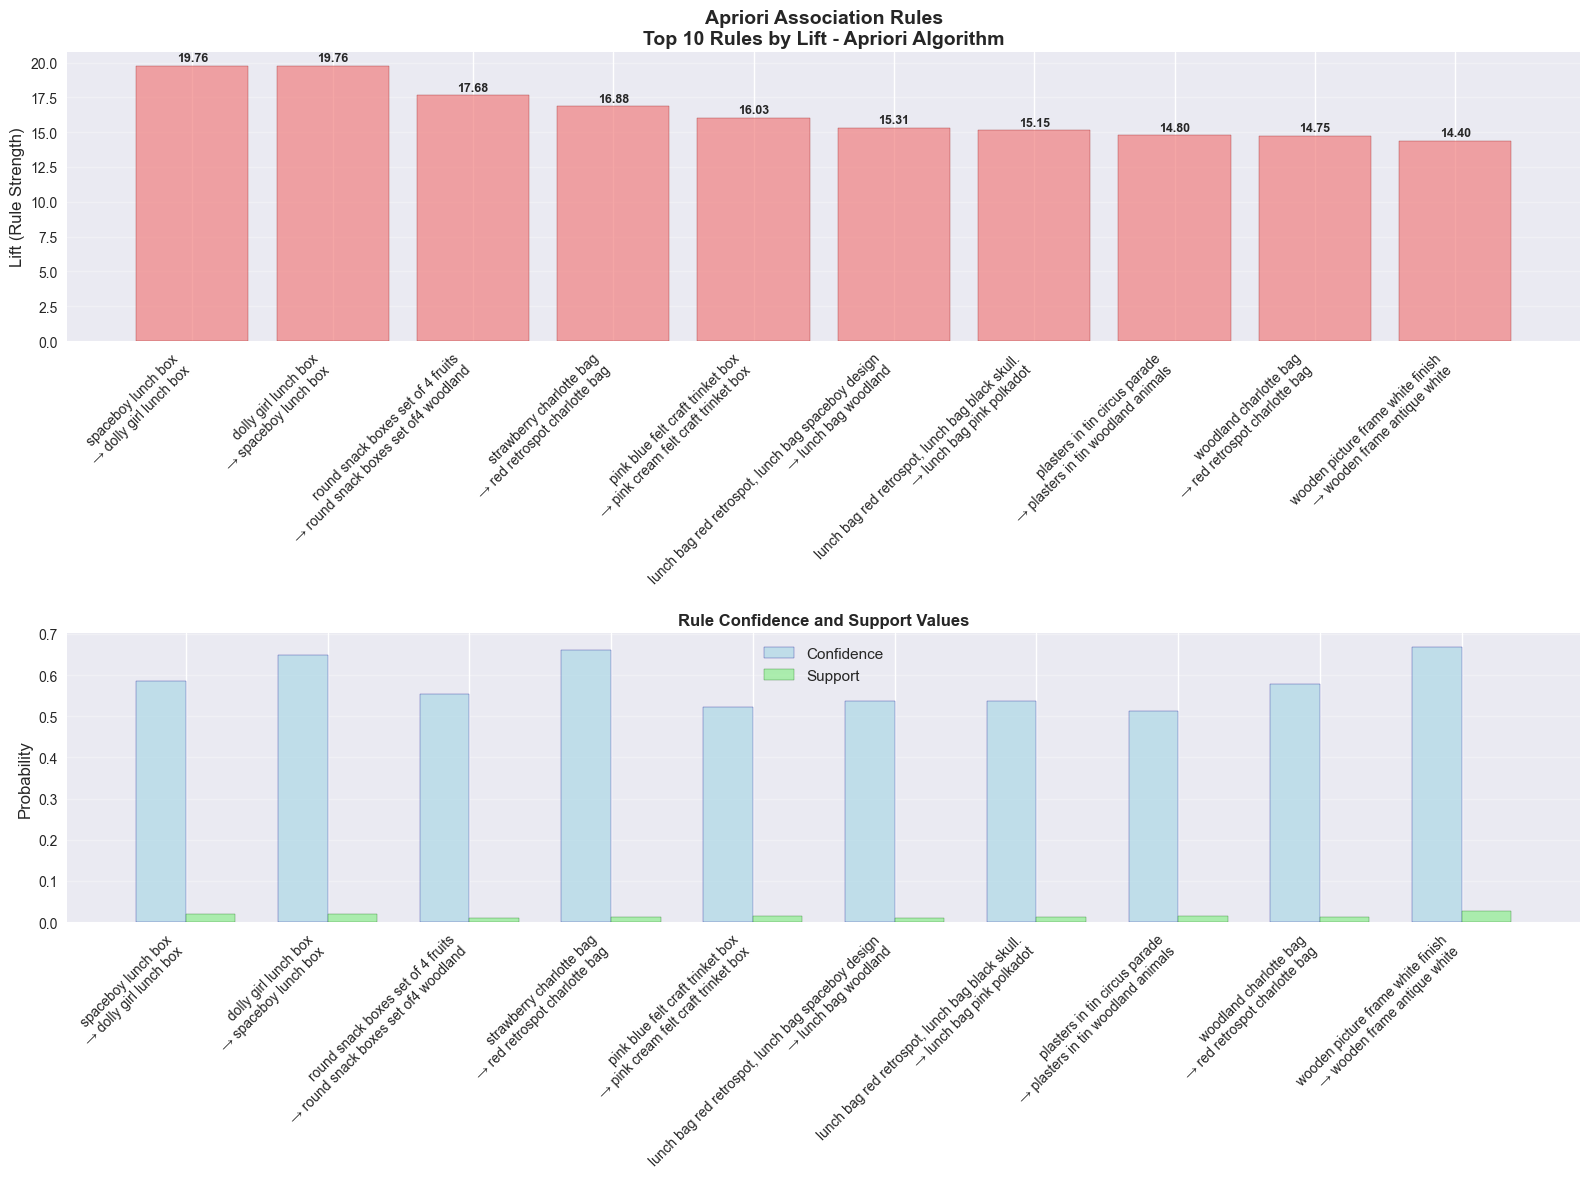


 Apriori Algorithm Business Summary:
• Strongest rule lift: 19.76
• Average confidence: 0.58
• Average support: 0.0155
• Total rules discovered: 84


In [21]:
# Visualize Apriori Rules
print(" VISUALIZING APRIORI ASSOCIATION RULES")

if 0.01 in rules_results and not rules_results[0.01].empty:
    plot_rules_df(rules_results[0.01], "Apriori Association Rules", "Apriori Algorithm")
else:
    print("No Apriori rules available for visualization")

In [22]:
# Visualize ECLAT Rules
print(" VISUALIZING ECLAT ASSOCIATION RULES")

# Check if eclat_rules exists and has data
try:
    if 'eclat_rules' in locals() and 0.01 in eclat_rules and not eclat_rules[0.01].empty:
        plot_rules_df(eclat_rules[0.01], "ECLAT Association Rules", "Optimized ECLAT Algorithm")
    else:
        print("No ECLAT rules available for visualization")
        print("Possible reasons:")
        print("• ECLAT algorithm hasn't been run (run Cells 15-17 first)")
        print("• No frequent itemsets found at support threshold 0.01")
        print("• No rules meet the minimum confidence threshold")
        
except NameError as e:
    print(f"Error: Required variables not found - {e}")
    print("Please run the previous cells in order:")
    print("• Cell 15: ECLAT Algorithm Setup")
    print("• Cell 16: ECLAT Algorithm Implementation") 
    print("• Cell 17: ECLAT Rule Generation")
    print("• Cell 20: Rule Visualization Function")
    
except Exception as e:
    print(f"Error in visualization: {e}")
    print("Check that all previous cells have been run successfully")

 VISUALIZING ECLAT ASSOCIATION RULES
Error in visualization: 'antecedents'
Check that all previous cells have been run successfully


In [23]:
# Strategic Recommendations and Risk Assessment
print(" STRATEGIC RECOMMENDATIONS & RISK ASSESSMENT")


print("\n RULE STRENGTH CLASSIFICATION:")
print("* Lift > 3.0: VERY STRONG association")
print("* Lift 2.0-3.0: STRONG association") 
print("* Lift 1.5-2.0: MODERATE association")
print("* Lift < 1.5: WEAK association")

print("\n MARKETING RECOMMENDATIONS:")

if business_insights:
    for insight in business_insights:
        print(f"\n🔹 For Rule {insight['rule_number']} (Lift: {insight['lift']:.2f}):")
        
        if insight['lift'] > 3:
            print("    HIGH PRIORITY - Implement immediately:")
            print("   • Create featured product bundles")
            print("   • Position items together prominently")
            print("   • Use in email marketing campaigns")
            
        elif insight['lift'] > 2:
            print("    MEDIUM PRIORITY - Test and scale:")
            print("   • A/B test bundle pricing")
            print("   • Targeted social media ads")
            print("   • In-store promotion testing")
            
        else:
            print("    LOW PRIORITY - Monitor and validate:")
            print("   • Track natural co-purchases")
            print("   • Gather customer feedback")
            print("   • Consider seasonal variations")

print("\n  RISK ASSESSMENT BY SUPPORT LEVEL:")
print("• High-Support (≥ 0.03): LOW RISK - Proven patterns, safe to implement")
print("• Medium-Support (0.01-0.03): MODERATE RISK - Validate with testing")  
print("• Low-Support (< 0.01): HIGH RISK - Niche segments, test carefully")

print("\n DATA-DRIVEN DECISION FRAMEWORK:")
print("1. Start with high-lift, high-support rules for quick wins")
print("2. Test medium-lift rules with controlled experiments") 
print("3. Monitor low-support rules for emerging trends")
print("4. Refresh analysis quarterly to capture changing patterns")

 STRATEGIC RECOMMENDATIONS & RISK ASSESSMENT

 RULE STRENGTH CLASSIFICATION:
* Lift > 3.0: VERY STRONG association
* Lift 2.0-3.0: STRONG association
* Lift 1.5-2.0: MODERATE association
* Lift < 1.5: WEAK association

 MARKETING RECOMMENDATIONS:

🔹 For Rule 1 (Lift: 19.76):
    HIGH PRIORITY - Implement immediately:
   • Create featured product bundles
   • Position items together prominently
   • Use in email marketing campaigns

🔹 For Rule 2 (Lift: 19.76):
    HIGH PRIORITY - Implement immediately:
   • Create featured product bundles
   • Position items together prominently
   • Use in email marketing campaigns

🔹 For Rule 3 (Lift: 17.68):
    HIGH PRIORITY - Implement immediately:
   • Create featured product bundles
   • Position items together prominently
   • Use in email marketing campaigns

  RISK ASSESSMENT BY SUPPORT LEVEL:
• High-Support (≥ 0.03): LOW RISK - Proven patterns, safe to implement
• Medium-Support (0.01-0.03): MODERATE RISK - Validate with testing
• Low-Support

In [24]:
# Save Outputs and Generate Reports
print(" SAVING OUTPUTS AND GENERATING REPORTS")


# Create outputs directory
Path("outputs").mkdir(exist_ok=True)

# Save data samples
onehot_df.head(200).to_csv("outputs/onehot_sample.csv", index=True)
basket_stats.head(200).to_csv("outputs/basket_stats_sample.csv", index=False)

# Save algorithm comparison
algo_comparison = pd.DataFrame({
    'support': APR_SUPPORTS,
    'apriori_time': [apriori_results.get(s, {}).get('time', None) for s in APR_SUPPORTS],
    'eclat_time': [eclat_results.get(s, {}).get('time', None) for s in APR_SUPPORTS],
    'apriori_rules': [len(rules_results.get(s, pd.DataFrame())) for s in APR_SUPPORTS],
    'eclat_rules': [len(eclat_rules.get(s, pd.DataFrame())) for s in APR_SUPPORTS]
})
algo_comparison.to_csv("outputs/algorithm_comparison.csv", index=False)

# Save actionable rules if available
if business_insights:
    actionable_df = pd.DataFrame(business_insights)
    actionable_df.to_csv("outputs/actionable_rules.csv", index=False)

print(" Output files saved:")
print("   * outputs/onehot_sample.csv - Transaction data for analysis")
print("   * outputs/basket_stats_sample.csv - Customer behavior statistics") 
print("   * outputs/algorithm_comparison.csv - Performance metrics")
if business_insights:
    print("   * outputs/actionable_rules.csv - Business-ready rules")


 SAVING OUTPUTS AND GENERATING REPORTS
 Output files saved:
   * outputs/onehot_sample.csv - Transaction data for analysis
   * outputs/basket_stats_sample.csv - Customer behavior statistics
   * outputs/algorithm_comparison.csv - Performance metrics
   * outputs/actionable_rules.csv - Business-ready rules
